In [8]:
import pandas as pd

In [9]:
df = pd.read_csv("sway_static_features.csv")
df.shape

(90, 137)

In [10]:
df.isna().sum().sort_values(ascending=False)


AREA_CE_Unilateral-Stance-Eyes-Closed     67
MFREQ_AP_Unilateral-Stance-Eyes-Closed    67
MFREQ_ML_Unilateral-Stance-Eyes-Closed    67
MVELO_AP_Unilateral-Stance-Eyes-Closed    67
MVELO_Unilateral-Stance-Eyes-Closed       67
                                          ..
height                                     0
weight                                     0
BMI                                        0
recorded_in_the_lab                        0
faller                                     0
Length: 137, dtype: int64

In [11]:
from sklearn.impute import SimpleImputer

# 1. Drop columns with >50% missing values
too_missing = df.columns[df.isna().mean() > 0.5]
df = df.drop(columns=too_missing)

# 2. Impute numerics with median
num_cols = df.select_dtypes(include=['float64','int64']).columns
imp_num = SimpleImputer(strategy='median')
df[num_cols] = imp_num.fit_transform(df[num_cols])

# 3. Impute categoricals with mode
cat_cols = df.select_dtypes(include=['object']).columns
imp_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imp_cat.fit_transform(df[cat_cols])

# df is now clean + ready for ML
clean_features = df
clean_features.shape


(90, 121)

In [12]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# ---------------------------
# 1. Load your clean data
# ---------------------------
# If you already have final_features in memory, skip this line:
final_features = clean_features

df = final_features.copy()

# ---------------------------
# 2. Clean / prepare a few columns
# ---------------------------

# Handle the special age value '>89' by mapping to 90
if "age" in df.columns:
    df["age_num"] = pd.to_numeric(
        df["age"].replace({">89": "90"}),
        errors="coerce"
    )
else:
    df["age_num"] = None  # if age isn't there, this does nothing later

# Target variable
y = df["faller"].astype(int)

# ---------------------------
# 3. Define feature columns
# ---------------------------

# Columns that should NOT be used as features
non_feature_cols = {"part_id", "faller", "age", "group"}  # we'll use age_num instead of age

# Numeric features: all numeric columns except non-feature ones
num_features = [
    c for c in df.select_dtypes(include=["int64", "float64"]).columns
    if c not in non_feature_cols
]

# Categorical features: object / category columns (e.g. group)
cat_features = [
    c for c in df.select_dtypes(include=["object"]).columns
    if c not in non_feature_cols
]

print("Numeric features:", len(num_features))
print("Categorical features:", cat_features)

# ---------------------------
# 4. Build preprocessing + model pipeline
# ---------------------------

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # helpful if classes are imbalanced
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])

# ---------------------------
# 5. Evaluate with stratified CV
# ---------------------------

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    clf,
    df[num_features + cat_features],
    y,
    cv=cv,
    scoring="roc_auc",
)

print("ROC-AUC (5-fold):", scores.mean(), "+/-", scores.std())

# ---------------------------
# 6. Fit final model on all data
# ---------------------------

clf.fit(df[num_features + cat_features], y)

# Now `clf` is your trained model; you can call:
# clf.predict(...)
# clf.predict_proba(...)


Numeric features: 117
Categorical features: ['age_num']
ROC-AUC (5-fold): 0.558956043956044 +/- 0.1875309095804258


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report

# XGBoost
try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    print("xgboost not installed")
    has_xgb = False

# ----------------------------------------------------
# LOAD PARTICIPANT-LEVEL FEATURE TABLE
# ----------------------------------------------------

df = final_features.copy()

# Target
y = df["faller"].astype(int)

# Handle age if needed
if "age" in df.columns and "age_num" not in df.columns:
    df["age_num"] = pd.to_numeric(df["age"].replace({">89": "90"}), errors="coerce")

# Feature columns
non_feature_cols = {"part_id", "faller", "age", "group"}  # age_num is used instead
num_features = [
    c for c in df.select_dtypes(include=["int64", "float64"]).columns
    if c not in non_feature_cols
]
cat_features = [
    c for c in df.select_dtypes(include=["object"]).columns
    if c not in non_feature_cols
]

X = df[num_features + cat_features]

# ----------------------------------------------------
# TRAIN / TEST SPLIT  (important!)
# ----------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ----------------------------------------------------
# PREPROCESSING
# ----------------------------------------------------

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

# ----------------------------------------------------
# MODELS
# ----------------------------------------------------

models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, class_weight="balanced", random_state=42
    ),
    "SVM_RBF": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
}

if has_xgb:
    models["XGBoost"] = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        tree_method="hist",
        random_state=42,
    )

# ----------------------------------------------------
# 5-fold CV on TRAIN ONLY
# ----------------------------------------------------

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n=== CV RESULTS ON TRAINING SET ===\n")

for name, model in models.items():
    clf = Pipeline([("preprocess", preprocess), ("model", model)])
    scores = cross_val_score(
        clf, X_train, y_train, cv=cv, scoring="roc_auc"
    )
    print(f"{name:12s} ROC-AUC CV: {scores.mean():.3f} ± {scores.std():.3f}")

# ----------------------------------------------------
# FINAL TEST EVALUATION
# ----------------------------------------------------

print("\n=== TEST SET EVALUATION ===\n")

for name, model in models.items():
    clf = Pipeline([("preprocess", preprocess), ("model", model)])
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"{name:12s} TEST ROC-AUC: {auc:.3f}")
    print("Classification report:")
    print(classification_report(y_test, clf.predict(X_test)))
    print("-" * 40)


xgboost not installed

=== CV RESULTS ON TRAINING SET ===

LogReg       ROC-AUC CV: 0.536 ± 0.115
RandomForest ROC-AUC CV: 0.648 ± 0.156
SVM_RBF      ROC-AUC CV: 0.453 ± 0.170

=== TEST SET EVALUATION ===

LogReg       TEST ROC-AUC: 0.646
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.50      0.80      0.62         5

    accuracy                           0.72        18
   macro avg       0.70      0.75      0.70        18
weighted avg       0.79      0.72      0.74        18

----------------------------------------
RandomForest TEST ROC-AUC: 0.800
Classification report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       1.00      0.40      0.57         5

    accuracy                           0.83        18
   macro avg       0.91      0.70      0.73        18
weighted avg       0.86      0.83      0.8

xgboost not installed; XGBoost will be skipped.
Numeric features: 118
Categorical features: []
=== CV RESULTS ON TRAINING SET (with oversampling in each fold) ===
LogReg       ROC-AUC: 0.546 ± 0.114
RandomForest ROC-AUC: 0.650 ± 0.130
SVM_RBF      ROC-AUC: 0.470 ± 0.219
=== TEST SET EVALUATION (single held-out split) ===
LogReg       TEST ROC-AUC: 0.615, PR-AUC: 0.378
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.50      0.80      0.62         5

    accuracy                           0.72        18
   macro avg       0.70      0.75      0.70        18
weighted avg       0.79      0.72      0.74        18

------------------------------------------------------------
RandomForest TEST ROC-AUC: 0.892, PR-AUC: 0.775
Classification report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       1.00      0.40     

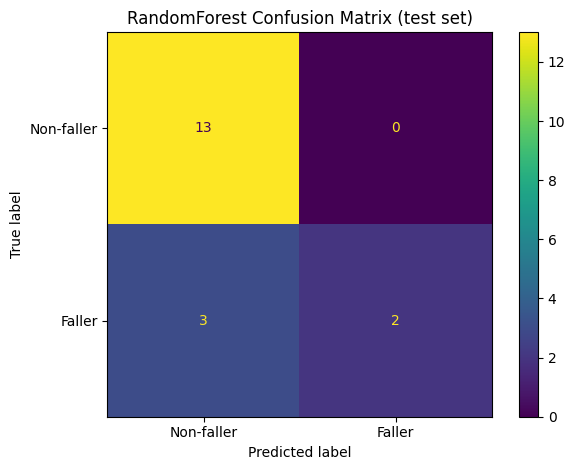

In [14]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
from joblib import dump

# Try XGBoost
try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    print("xgboost not installed; XGBoost will be skipped.")
    has_xgb = False


# ----------------------------------------------------
# 1. Load / prepare data
# ----------------------------------------------------

# If you already have final_features in memory, skip this and use that.
# final_features = pd.read_csv("final_features.csv")


# Target: faller (0 = non-faller, 1 = faller)
y = df["faller"].astype(int)

# Optional: clean age into numeric (if you still have string age)
if "age" in df.columns and "age_num" not in df.columns:
    df["age_num"] = pd.to_numeric(
        df["age"].replace({">89": "90"}),
        errors="coerce"
    )

# ---------------------------
# Define feature columns
# ---------------------------

# Columns NOT to use as features
non_feature_cols = {"part_id", "faller", "age", "group"}  # drop group to avoid leakage

# If you *don’t* want clinically-at-risk used as a feature, add it here:
non_feature_cols.add("clinically-at-risk")

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
num_features = [c for c in numeric_cols if c not in non_feature_cols]

categorical_cols = df.select_dtypes(include=["object"]).columns
cat_features = [c for c in categorical_cols if c not in non_feature_cols]

print("Numeric features:", len(num_features))
print("Categorical features:", cat_features)

X = df[num_features + cat_features]


# ----------------------------------------------------
# 2. Train / Test split (stratified)
# ----------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)


# ----------------------------------------------------
# 3. Preprocessing + Oversampling
# ----------------------------------------------------

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

# Oversampler: only applied on training folds / training set
oversampler = RandomOverSampler(random_state=42)


# ----------------------------------------------------
# 4. Define models with imbalance handling
# ----------------------------------------------------

models = {}

# Logistic Regression with class weights
models["LogReg"] = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
)

# Random Forest with class weights
models["RandomForest"] = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

# SVM (RBF) with class weights
models["SVM_RBF"] = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced",
    random_state=42,
)

# XGBoost with scale_pos_weight
if has_xgb:
    pos = y_train.sum()
    neg = len(y_train) - pos
    scale_pos_weight = neg / pos if pos > 0 else 1.0

    models["XGBoost"] = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        scale_pos_weight=scale_pos_weight,
        random_state=42,
    )


# ----------------------------------------------------
# 5. Cross-validated evaluation (TRAINING ONLY)
# ----------------------------------------------------

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("=== CV RESULTS ON TRAINING SET (with oversampling in each fold) ===")

cv_results = {}

for name, model in models.items():
    clf = ImbPipeline(steps=[
        ("preprocess", preprocess),
        ("oversample", oversampler),
        ("model", model),
    ])

    scores = cross_val_score(
        clf,
        X_train,
        y_train,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
    )

    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name:12s} ROC-AUC: {scores.mean():.3f} ± {scores.std():.3f}")


# ----------------------------------------------------
# 6. Final evaluation on TEST SET
# ----------------------------------------------------

print("=== TEST SET EVALUATION (single held-out split) ===")

test_results = {}
fitted_models = {}

for name, model in models.items():
    clf = ImbPipeline(steps=[
        ("preprocess", preprocess),
        ("oversample", oversampler),
        ("model", model),
    ])

    clf.fit(X_train, y_train)

    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    roc = roc_auc_score(y_test, y_proba)
    pr  = average_precision_score(y_test, y_proba)

    test_results[name] = {"ROC-AUC": roc, "PR-AUC": pr}
    fitted_models[name] = clf

    print(f"{name:12s} TEST ROC-AUC: {roc:.3f}, PR-AUC: {pr:.3f}")
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)


# ----------------------------------------------------
# 7. Pick a best model (example: highest TEST ROC-AUC)
# ----------------------------------------------------

best_name = max(test_results, key=lambda k: test_results[k]["ROC-AUC"])
best_model = fitted_models[best_name]

print(f"Best model by TEST ROC-AUC: {best_name}")

# Save the best model using its name so it is clear what was selected
model_filename = f"{best_name}_model.joblib"
dump(best_model, model_filename)
print(f"Best model saved to: {model_filename}")

# Confusion matrix on the held-out test set for the best model
best_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_pred, labels=[0, 1])

print("Confusion matrix (rows=true, cols=pred):")
print(cm)

ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-faller", "Faller"],
).plot(values_format="d")
plt.title(f"{best_name} Confusion Matrix (test set)")
plt.tight_layout()
plt.show()
